Import the relevant libraries.



In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
# from scipy import optimize
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# import matplotlib.pyplot as plt
# import tensorflow as tf
# import altair as alt
# from linearmodels.iv import IV2SLS
# from tensorflow.keras import datasets, layers, models
# from tensorflow import keras
# import theano
# import pymc3 as pm
# import arviz as az
# import seaborn as sn


# import covid19pandas as cod
from country_codes import eurostat_dictionary
import eurostat
import matplotlib.pyplot as plt


from warnings import filterwarnings
filterwarnings('ignore')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

## Dealing with data



In this section we work with the API of Eurostat to get data directly into the notebook.

We look at the data for each variable, decide on the shape we want to have for the dataframe and then merge a number of data sets together. For this we will be using pandas. Further, we use the python file `country_codes.py` which should be in the same folder as this notebook.



### Countries



We focus on the following countries when looking at the data. For the Eurostat data this does not matter so much. But if you want to combine Eurostat data with OECD data, this selection can be useful.



In [40]:
EU_countries = ['Belgium', 'Bulgaria', 'Czechia', 'Denmark',
'Germany (until 1990 former territory of the FRG)', 'Germany','Estonia',
'Ireland', 'Greece', 'Spain', 'France', 'Croatia', 'Italy',
'Cyprus', 'Latvia', 'Lithuania', 'Luxembourg', 'Hungary', 'Malta',
'Netherlands', 'Austria', 'Poland', 'Portugal', 'Romania',
'Slovenia', 'Slovakia', 'Finland', 'Sweden', 'United Kingdom',
'Iceland', 'Liechtenstein', 'Norway', 'Switzerland',
'Bosnia and Herzegovina']

### Mortality



The [Eurostat website](https://ec.europa.eu/eurostat/data/database?node_code=hlth_cd_apr) has a browser where you can look for data. Here we are looking for data on mortality. You can click on the link to the data browser to see the [details of the variable](https://ec.europa.eu/eurostat/databrowser/view/hlth_cd_apr/default/table?lang=en). At the top-left of the screen you can see the name of the variable in the line &ldquo;`online data code: HLTH_CD_APR`&rdquo;. The name of this variable we use below in the `get_data_df` method.

So we call this method and collect the information in the dataframe `df`. Then we check what `df` looks like:



In [41]:
df = eurostat.get_data_df('hlth_cd_apr')
df.head()

,freq,mortalit,sex,icd10,unit,geo\TIME_PERIOD,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,A,PRVT,F,A00-A09,NR,AT,7.0,12.0,9.0,6.0,5.0,15.0,10.0,8.0,6.0,13.0
1,A,PRVT,F,A00-A09,NR,BE,25.0,11.0,20.0,26.0,26.0,27.0,45.0,26.0,44.0,39.0
2,A,PRVT,F,A00-A09,NR,BG,5.0,4.0,10.0,11.0,13.0,7.0,4.0,3.0,4.0,5.0
3,A,PRVT,F,A00-A09,NR,CH,14.0,14.0,9.0,9.0,5.0,13.0,13.0,11.0,14.0,10.0
4,A,PRVT,F,A00-A09,NR,CY,6.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0


So we have a number of columns with abbreviations in them and then we have data for the years 2011-2017. Use the website of the variable to figure out what the abbreviations mean. To illustrate, the column `mortalit` gives three measures of mortality:



In [5]:
df.mortalit.unique()

array(['PRVT', 'TOTAL', 'TRT'], dtype=object)

We will be interested in preventable &rsquo;PRVT&rsquo; and treatable &rsquo;TRT&rsquo; mortality.

First, let&rsquo;s change the country column &rsquo;geo\time&rsquo; and use country names instead of abbreviations. We need to &ldquo;escape&rdquo; the &rsquo;\\&rsquo; symbol to make sure pandas reads &rsquo;\\&rsquo; literally (not as a symbol). That is why we have &rsquo;\\\\&rsquo; in the code below. We use the `eurostat_dictionary` to turn the country abbreviations into country names.

Note that to change the column name we use `.rename`; to change values in a row, we use `.replace`. The replacements are provided using a python dictionary: `{'old_name':'new_name'}`.

If you are wondering why we use `inplace=True`, just run the code block without this to see the difference.



In [6]:
df.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)
df['country'] = df['geo'].replace(eurostat_dictionary)
df.head()

,freq,mortalit,sex,icd10,unit,geo,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,country
0,A,PRVT,F,A00-A09,NR,AT,7.0,12.0,9.0,6.0,5.0,15.0,10.0,8.0,6.0,13.0,Austria
1,A,PRVT,F,A00-A09,NR,BE,25.0,11.0,20.0,26.0,26.0,27.0,45.0,26.0,44.0,39.0,Belgium
2,A,PRVT,F,A00-A09,NR,BG,5.0,4.0,10.0,11.0,13.0,7.0,4.0,3.0,4.0,5.0,Bulgaria
3,A,PRVT,F,A00-A09,NR,CH,14.0,14.0,9.0,9.0,5.0,13.0,13.0,11.0,14.0,10.0,Switzerland
4,A,PRVT,F,A00-A09,NR,CY,6.0,1.0,1.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,Cyprus


Now we will select the values that we are interested in: only EU countries, both males and females, both preventable and treatable mortality, unit of measurement rate &rsquo;RT&rsquo; (not number &rsquo;NR&rsquo;) and all diseases (e.g. not the subset &ldquo; [A00-A09] Intestinal infectious diseases&rdquo;).

For selection, we can use `==` or `.isin()`. With numbers we can also use smaller/greater than `<,>` etc.

After this selection, we can drop some columns to make the dataframe a bit easier to handle.



In [7]:
df = df[df.country.isin(EU_countries) & (df.sex.isin(["M","F"]) ) & (df.mortalit.isin(["PRVT","TRT"])) \
        & (df.unit == "RT") & (df.icd10 == "TOTAL")]
df.drop(["unit","icd10","geo"],axis=1,inplace=True)
df.head()

,freq,mortalit,sex,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,country
6300,A,PRVT,F,95.29,96.16,93.22,93.95,97.52,96.39,92.94,93.14,94.81,99.09,Austria
6301,A,PRVT,F,101.35,99.97,100.34,95.40,99.71,94.13,93.42,92.83,92.39,113.63,Belgium
6302,A,PRVT,F,119.32,126.17,119.29,129.04,128.32,120.14,121.87,119.05,120.05,177.73,Bulgaria
6303,A,PRVT,F,73.75,74.02,73.85,72.70,69.37,68.91,68.45,71.15,67.12,72.59,Switzerland
6304,A,PRVT,F,57.31,49.38,47.75,54.65,55.67,49.98,46.69,50.87,49.03,54.90,Cyprus


In [8]:
df = pd.melt(df,id_vars=['country','sex','mortalit'],
                        value_vars= df.columns[2:-1],
                        var_name='year',
                        value_name='rate')
df.head()

,country,sex,mortalit,year,rate
0,Austria,F,PRVT,2011,95.29
1,Belgium,F,PRVT,2011,101.35
2,Bulgaria,F,PRVT,2011,119.32
3,Switzerland,F,PRVT,2011,73.75
4,Cyprus,F,PRVT,2011,57.31


Instead of one column `rate` we want to have two columns (i.e. two variables); one corresponds to PRVT, the other to TRT. For this we use [unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html). We put the identifying columns in an order such that the last column refers to `mortalit` which contains the two values PRVT and TRT. These columns become the index of the dataframe. Then we unstack the dataframe on the last column of the index, which is the default value of `unstack()`. This pivots the column `mortalit` into two separate columns PRVT and TRT.



In [9]:
df.set_index(['country','year','sex','mortalit'],inplace=True)
df = df.unstack()
df.head()

rate       
mortalit            PRVT    TRT
country year sex               
Austria 2011 F     95.29  67.41
             M    248.50  96.86
        2012 F     96.16  69.72
             M    252.28  91.45
        2013 F     93.22  66.84

Finally, we reset the index (such that it no longer features the hierarchy &#x2013;with &rsquo;rate&rsquo; and &rsquo;mortalit&rsquo;&#x2013; shown above) and rename the columns to make them easier to read/understand.



In [10]:
df.reset_index(inplace=True)
df.columns = [' '.join(col).strip() for col in df.columns.values]
df.rename({'rate PRVT':'Preventable mortality', 'rate TRT':'Treatable mortality'},inplace=True,axis=1)
df.head()

,country,year,sex,Preventable mortality,Treatable mortality
0,Austria,2011,F,95.29,67.41
1,Austria,2011,M,248.50,96.86
2,Austria,2012,F,96.16,69.72
3,Austria,2012,M,252.28,91.45
4,Austria,2013,F,93.22,66.84


Now we consider a number of other variables. There you can practice the steps above to get these dataframes into the right shape. Finally, we merge each dataframe with the one previously created.



### GDP per capita



Go to this [page](https://ec.europa.eu/eurostat/data/database?node_code=nama_10_pc) to find the variable name for &ldquo;Main GDP aggregates per capita&rdquo;; fill in the &ldquo;dots&rdquo; in the following code:



In [11]:
df_n = eurostat.get_data_df('nama_10_pc')
df_n.head()

,freq,unit,na_item,geo\TIME_PERIOD,1975,1976,1977,1978,1979,1980,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,CLV10_EUR_HAB,B1GQ,AL,NaN,NaN,NaN,NaN,NaN,NaN,...,3260.0,3330.0,3410.0,3530.0,3670.0,3830.0,3920.0,3810.0,NaN,NaN
1,A,CLV10_EUR_HAB,B1GQ,AT,NaN,NaN,NaN,NaN,NaN,NaN,...,36180.0,36130.0,36140.0,36390.0,36980.0,37690.0,38070.0,35390.0,36740.0,38080.0
2,A,CLV10_EUR_HAB,B1GQ,BE,NaN,NaN,NaN,NaN,NaN,NaN,...,33490.0,33870.0,34360.0,34620.0,35040.0,35510.0,36110.0,34050.0,36230.0,37040.0
3,A,CLV10_EUR_HAB,B1GQ,BG,NaN,NaN,NaN,NaN,NaN,NaN,...,5390.0,5470.0,5700.0,5910.0,6120.0,6330.0,6630.0,6400.0,6950.0,7680.0
4,A,CLV10_EUR_HAB,B1GQ,CH,NaN,NaN,NaN,NaN,NaN,NaN,...,58650.0,59300.0,59600.0,60170.0,60420.0,61690.0,61950.0,60190.0,62950.0,64000.0


#### Question: make the following selections:



-   from the column `country` select EU countries
-   from `na_item` select &rsquo;B1GQ&rsquo;
-   from `unit` select &rsquo;CP<sub>EUR</sub><sub>HAB</sub>&rsquo;
-   then drop the columns `unit, na_item, geo`



#### The melt statement



The melt statement is easier now. Together with `year`, a column is uniquely identified by `country` only. Since we only have one variable here (GDP), we do not need to `unstack`.



In [12]:
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

df_n['country'] = df_n['geo'].replace(eurostat_dictionary)
# drop columns that contain all nan values
# Dropping columns with all NaN values
df_n.dropna(axis=1, how='all', inplace=True)

df_n.head()

,freq,unit,na_item,geo,1975,1976,1977,1978,1979,1980,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,country
0,A,CLV10_EUR_HAB,B1GQ,AL,NaN,NaN,NaN,NaN,NaN,NaN,...,3330.0,3410.0,3530.0,3670.0,3830.0,3920.0,3810.0,NaN,NaN,Albania
1,A,CLV10_EUR_HAB,B1GQ,AT,NaN,NaN,NaN,NaN,NaN,NaN,...,36130.0,36140.0,36390.0,36980.0,37690.0,38070.0,35390.0,36740.0,38080.0,Austria
2,A,CLV10_EUR_HAB,B1GQ,BE,NaN,NaN,NaN,NaN,NaN,NaN,...,33870.0,34360.0,34620.0,35040.0,35510.0,36110.0,34050.0,36230.0,37040.0,Belgium
3,A,CLV10_EUR_HAB,B1GQ,BG,NaN,NaN,NaN,NaN,NaN,NaN,...,5470.0,5700.0,5910.0,6120.0,6330.0,6630.0,6400.0,6950.0,7680.0,Bulgaria
4,A,CLV10_EUR_HAB,B1GQ,CH,NaN,NaN,NaN,NaN,NaN,NaN,...,59300.0,59600.0,60170.0,60420.0,61690.0,61950.0,60190.0,62950.0,64000.0,Switzerland


In [13]:
# Merge on 'country' and 'year' columns
df_n = pd.melt(df_n,id_vars=['country','unit'],
                        value_vars= df_n.columns[4:-1],
                        var_name='year',
                        value_name='gdp')

merged_df = df.merge(df_n, on=['country', 'year'], how='left') #
merged_df.head()

# dataframe with both mortalilty rates and GDP

,country,year,sex,Preventable mortality,Treatable mortality,unit,gdp
0,Austria,2011,F,95.29,67.41,CLV10_EUR_HAB,36300.0
1,Austria,2011,F,95.29,67.41,CLV10_EUR_HAB,26360.0
2,Austria,2011,F,95.29,67.41,CLV10_EUR_HAB,4410.0
3,Austria,2011,F,95.29,67.41,CLV10_EUR_HAB,18430.0
4,Austria,2011,F,95.29,67.41,CLV10_EUR_HAB,19130.0


### Income quantiles



Use [this page](https://ec.europa.eu/eurostat/databrowser/view/icw_res_02/default/table?lang=en) to get the variable name for &ldquo;Mean and median economic resources of households by income, consumption and wealth quantiles - experimental statistics&rdquo;.



We drop the year 2010 as it does not lie in the period for which we have the other data that we download.



In [14]:
df_n = eurostat.get_data_df('icw_res_02') #icw_res_02
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

df_n = df_n[(df_n.indic_il=='INC_DISP')&(df_n.statinfo=='AVG')&(df_n.quant_inc.isin(['QU1', 'QU2', 'QU3', 'QU4', 'QU5']))&(df_n.quant_expn=='TOTAL')&(df_n.quant_wlth=='TOTAL')]

df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo', '2010'],axis=1,inplace=True)
df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n.drop(['geo'],axis=1,inplace=True)

df_n = pd.melt(df_n,id_vars=['country','quant_inc'],
                        value_vars= df_n.columns[1:-1],
                        var_name='year',
                        value_name='mean/median income')

df_n.set_index(['country', 'year', 'quant_inc'], inplace=True)

df_n = df_n[df_n.index.duplicated(keep='last')] # removing duplicate indices

df_n.index.unique()

df_n = df_n.unstack(level='quant_inc')

df_n.head()

mean/median income                                    
quant_inc                    QU1      QU2      QU3      QU4      QU5
country  year                                                       
Austria  2015            16542.1  27955.8  36687.8  48214.5  74519.8
         2020            17597.6  32409.5  41893.2  52793.7  83297.4
Belgium  2015            15834.1  23310.6  33248.2  44849.9  68233.2
         2020            18600.4  27357.2  39019.0  52166.4  76766.2
Bulgaria 2015             1847.7   3270.1   5115.9   7451.6  14354.6

In [15]:
merged_df = df.merge(df_n.reset_index(), on=['country', 'year'], how='left')
merged_df.head()

,country,year,sex,Preventable mortality,Treatable mortality,"(mean/median income, QU1)","(mean/median income, QU2)","(mean/median income, QU3)","(mean/median income, QU4)","(mean/median income, QU5)"
0,Austria,2011,F,95.29,67.41,NaN,NaN,NaN,NaN,NaN
1,Austria,2011,M,248.50,96.86,NaN,NaN,NaN,NaN,NaN
2,Austria,2012,F,96.16,69.72,NaN,NaN,NaN,NaN,NaN
3,Austria,2012,M,252.28,91.45,NaN,NaN,NaN,NaN,NaN
4,Austria,2013,F,93.22,66.84,NaN,NaN,NaN,NaN,NaN


In [16]:
df_n = eurostat.get_data_df('lfsa_urgan') 
df_n.head()

,freq,unit,sex,age,citizen,geo\TIME_PERIOD,1995,1996,1997,1998,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,A,PC,F,Y15-19,EU27_2020_FOR,AT,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,PC,F,Y15-19,EU27_2020_FOR,BE,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A,PC,F,Y15-19,EU27_2020_FOR,BG,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A,PC,F,Y15-19,EU27_2020_FOR,CH,NaN,NaN,NaN,NaN,...,15.7,18.3,19.5,15.0,17.7,16.6,9.8,13.3,13.3,17.1
4,A,PC,F,Y15-19,EU27_2020_FOR,CY,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_n = eurostat.get_data_df('yth_demo_080')
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n.drop(['geo'],axis=1,inplace=True)
df_n.tail()

,freq,agedef,c_birth,unit,sex,age,2008,2009,2010,2011,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,country
250767,A,REACH,ZW,PC,T,Y25-29,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,North Macedonia
250768,A,REACH,ZW,PC,T,Y25-29,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netherlands
250769,A,REACH,ZW,PC,T,Y25-29,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Norway
250770,A,REACH,ZW,PC,T,Y25-29,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,Sweden
250771,A,REACH,ZW,PC,T,Y25-29,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,Slovakia


2008     17160.0
2009     16615.0
2010     21745.0
2011     28235.0
2012     24850.0
2013     31125.0
2014     33815.0
2015    107255.0
2016    148155.0
2017     89880.0
2018     58105.0
2019     50280.0
2020     24525.0
2021     19310.0
2022     17460.0
dtype: float64


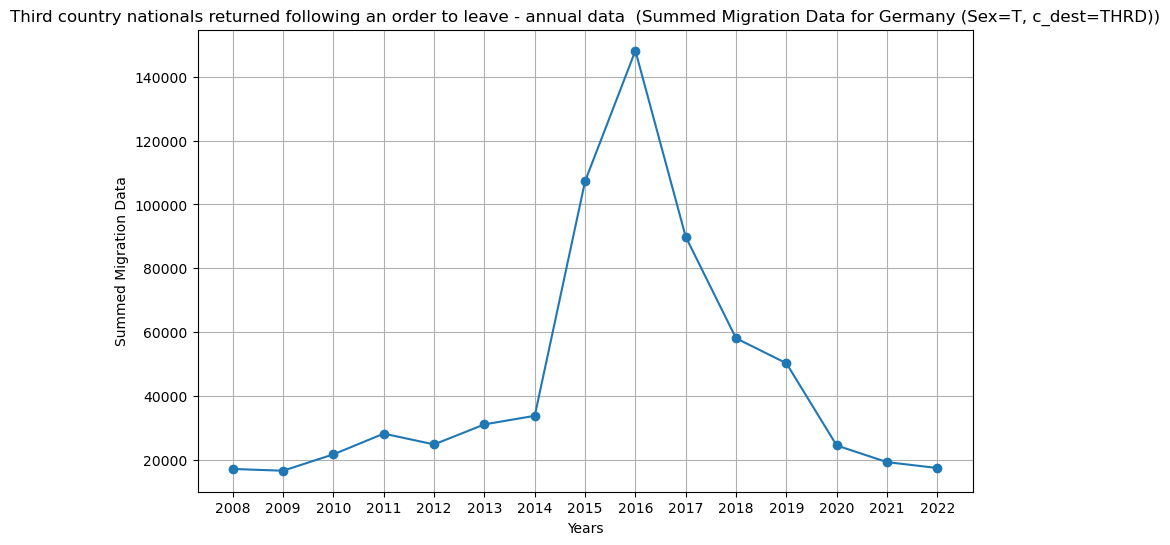

In [56]:

df_n = eurostat.get_data_df('migr_eirtn')
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n = df_n[df_n['age']== 'TOTAL']

df_n.set_index(['country','freq', 'c_dest', 'age', 'sex'], inplace=True)

df_n.drop(['geo'],axis=1,inplace=True)


# plot the first index and use each column on the x-axis

# Assuming your DataFrame is named df_n

# Reset index to access 'country', 'freq', 'c_dest', 'age', 'sex' as columns
df_n_reset = df_n.reset_index()

# Assuming 'year_columns' represents the columns that contain years
year_columns = [col for col in df_n_reset.columns if col not in ['country', 'freq', 'c_dest', 'age', 'sex', 'citizen', 'unit']]

# Plotting for a specific country (e.g., 'Germany') and all the years

country_data = df_n_reset[df_n_reset['country'] == 'Germany']
country_data = country_data[country_data['sex'] == 'T']
country_data = country_data[country_data['c_dest'] == 'THRD']



# Selecting columns representing years
year_columns = [col for col in country_data.columns if col not in ['country', 'freq', 'c_dest', 'age', 'sex', 'citizen', 'unit']]

# Summing over rows for each year
summed_data = country_data[year_columns].sum()
print(summed_data)

# Plotting the summed data
plt.figure(figsize=(10, 6))
plt.plot(summed_data.index, summed_data.values, marker='o', linestyle='-')
plt.xlabel('Years')
plt.ylabel('Summed Migration Data')
plt.title('Third country nationals returned following an order to leave - annual data  (Summed Migration Data for Germany (Sex=T, c_dest=THRD))')
plt.grid(True)
plt.show()


In [18]:

df_n = eurostat.get_data_df('hlth_ehis_al3e') # ALCOHOL DATA
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

# Frequency of heavy episodic drinking by sex, age and educational attainment level

# df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo', '2010'],axis=1,inplace=True)
df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n.drop(['geo'],axis=1,inplace=True)

# df_n = pd.melt(df_n,id_vars=['country','quant_inc'],
                        # value_vars= df_n.columns[1:-1],
                        # var_name='year',
                        # value_name='mean/median income')

# df_n.set_index(['country', 'year', 'quant_inc'], inplace=True)

# df_n = df_n[df_n.index.duplicated(keep='last')] # removing duplicate indices

# df_n.index.unique()

# df_n = df_n.unstack(level='quant_inc')

df_n.head()

,freq,unit,frequenc,isced11,sex,age,2014,2019,country
0,A,PC,GE1W,ED0-2,F,TOTAL,0.7,0.9,Austria
1,A,PC,GE1W,ED0-2,F,TOTAL,2.3,2.9,Belgium
2,A,PC,GE1W,ED0-2,F,TOTAL,0.4,0.4,Bulgaria
3,A,PC,GE1W,ED0-2,F,TOTAL,0.0,0.0,Cyprus
4,A,PC,GE1W,ED0-2,F,TOTAL,1.1,0.3,Czechia


MultiIndex([('T', 'Y16-19', 'Belgium'),
            ('T', 'Y16-24', 'Belgium'),
            ('T', 'Y16-29', 'Belgium'),
            ('T', 'Y18-24', 'Belgium'),
            ('T', 'Y18-34', 'Belgium'),
            ('T', 'Y20-24', 'Belgium'),
            ('T', 'Y20-29', 'Belgium'),
            ('T', 'Y25-29', 'Belgium'),
            ('T', 'Y25-34', 'Belgium')],
           names=['sex', 'age', 'country'])


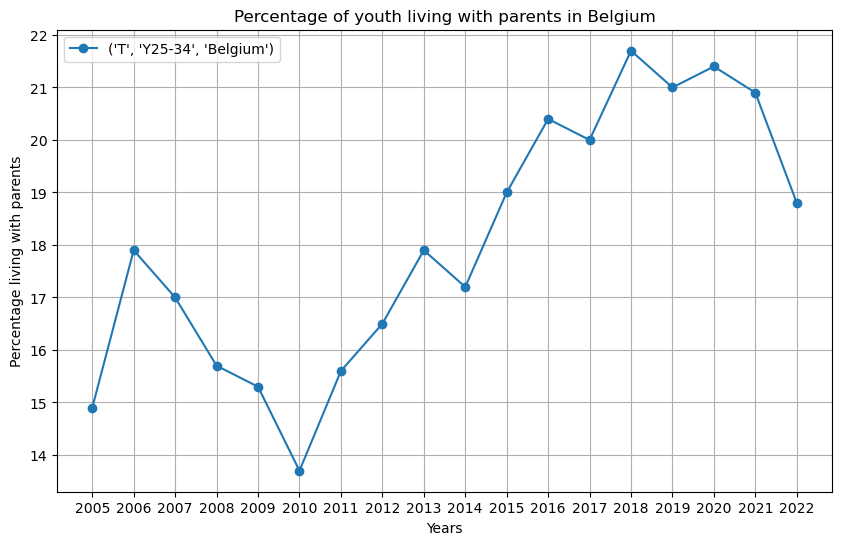

In [112]:

df_n = eurostat.get_data_df('ilc_lvps08') # YOUNG PEOPLE LIVING AT HOME
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

# Frequency of heavy episodic drinking by sex, age and educational attainment level

# df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo', '2010'],axis=1,inplace=True)

df_n.drop(['unit', 'freq'],axis=1,inplace=True)
df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n.drop(['geo'],axis=1,inplace=True)

COUNTRY = 'Belgium'

df_n = df_n[df_n['country'] == COUNTRY]
df_n = df_n[df_n['sex'] == 'T']

df_n.drop(['2003', '2004'],axis=1, inplace=True) # 'sex', 'age', 'country', 

df_n.set_index(['sex', 'age', 'country'], inplace=True)
print(df_n.index)
df_n = df_n.tail(1)
df_n = df_n.T

# Assuming df_n is your modified DataFrame
plt.figure(figsize=(10, 6))

for column in df_n.columns:

    plt.plot(df_n.index, df_n[column], marker='o', linestyle='-', label=column)

plt.xlabel('Years')
plt.ylabel('Percentage living with parents')
plt.title(f'Percentage of youth living with parents in {COUNTRY}')
plt.legend()  # Add a legend to differentiate the columns
plt.grid(True)
plt.show()

# print(df_n)
# # Plotting the summed data
# plt.figure(figsize=(10, 6))

# plt.plot(df_n.values, marker='o', linestyle='-')
# plt.xlabel('Years')
# plt.ylabel('Percentage living with parents')
# plt.title('percentage dutch youth living with parents')
# plt.grid(True)
# plt.show()

                        1999  2000  2001  2002  2003  2004  2005  2006  2007  \
sex age    country                                                             
T   Y15-29 Netherlands   1.2   0.4   0.3   0.3   0.7   1.0   2.0   1.6   1.0   

                        2008  ...  2013  2014  2015  2016  2017  2018  2019  \
sex age    country            ...                                             
T   Y15-29 Netherlands   0.8  ...   2.1   2.3   2.0   1.6   1.1   0.7   0.6   

                        2020  2021  2022  
sex age    country                        
T   Y15-29 Netherlands   0.7   0.5   0.3  

[1 rows x 24 columns]


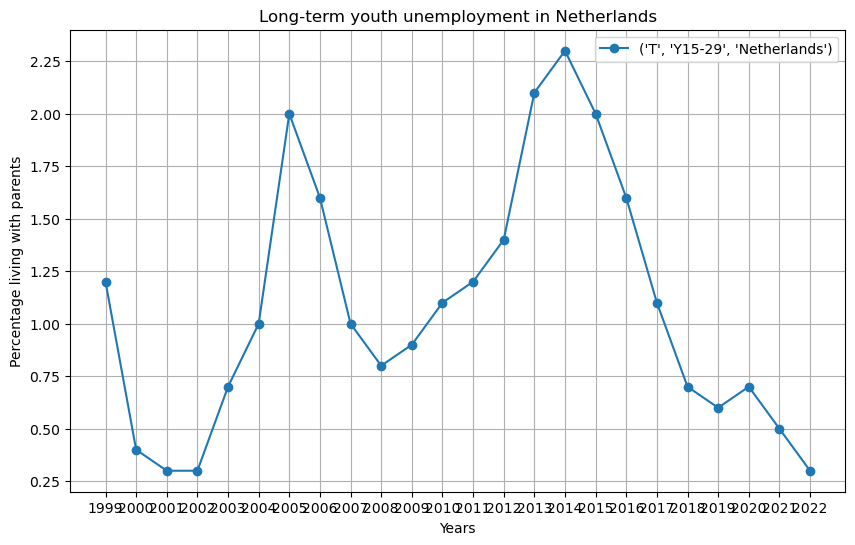

In [118]:


df_n = eurostat.get_data_df('yth_empl_130') # Long-term youth unemployment
df_n.rename({'geo\TIME_PERIOD':'geo'},inplace=True,axis=1)

# Frequency of heavy episodic drinking by sex, age and educational attainment level

# df_n.drop(['unit','quant_expn','quant_wlth','indic_il','statinfo', '2010'],axis=1,inplace=True)

df_n.drop(['unit', 'freq'],axis=1,inplace=True)
df_n['country'] = df_n['geo'].replace(eurostat_dictionary)

df_n.drop(['geo'],axis=1,inplace=True)

COUNTRY = 'Netherlands'

df_n = df_n[df_n['country'] == COUNTRY]
df_n = df_n[df_n['sex'] == 'T']

df_n.set_index(['sex', 'age', 'country'], inplace=True)
print(df_n)
# df_n = df_n.tail(1)
df_n = df_n.T

# Assuming df_n is your modified DataFrame
plt.figure(figsize=(10, 6))

for column in df_n.columns:
    plt.plot(df_n.index, df_n[column], marker='o', linestyle='-', label=column)

plt.xlabel('Years')
plt.ylabel('Percentage living with parents')
plt.title(f'Long-term youth unemployment in {COUNTRY}')
plt.legend()  # Add a legend to differentiate the columns
plt.grid(True)
plt.show()

## Loading worldbank data

In [19]:
from pandas_datareader import wb
wbdata = (wb.download(indicator='NY.GDP.MKTP.CD', country='all', start=1994, end=2015)
            .dropna()
            .rename(columns={'NY.GDP.MKTP.CD': 'gdp'})
            )
print(type(wbdata))

<class 'pandas.core.frame.DataFrame'>


In [20]:
wbdata

gdp
country                     year              
Africa Eastern and Southern 2015  9.273485e+11
                            2014  1.006526e+12
                            2013  9.859871e+11
                            2012  9.753548e+11
                            2011  9.678246e+11
...                                        ...
Zimbabwe                    1998  6.401968e+09
                            1997  8.529572e+09
                            1996  8.553147e+09
                            1995  7.111271e+09
                            1994  6.890675e+09

[5522 rows x 1 columns]